In [1]:
import re
import html
import numpy as np
import pandas as pd
import spacy
from string import punctuation
from math import sqrt, ceil
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
# plotting
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
# progress bars
from tqdm import tqdm
tqdm.pandas()

#### Import custom text preprocessing class for this exercise
For this dataset, the class `Textpreprocessor` is defined in the file `custom_preprocessing.py`.

In [2]:
from custom_preprocessing import TextPreprocessor

### Read in New York Times Dataset
A pre-processed version of the NYT news dataset is read in as a DataFrame.

In [3]:
data_path = "../data/nytimes.tsv"

df = pd.read_csv(data_path, sep='\t', header=None,
                 names=['date', 'headline', 'content'])
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.head()

date                                           headline  \
0 2016-06-30  washington nationals max scherzer baffles mets...   
1 2016-06-30  mayor de blasios counsel to leave next month t...   
2 2016-06-30  three men charged in killing of cuomo administ...   
3 2016-06-30  tekserve precursor to the apple store to close...   
4 2016-06-30  once at michael phelpss feet and still chasing...   

                                             content  
0  Stellar pitching kept the Mets afloat in the f...  
1  Mayor Bill de Blasio’s counsel and chief legal...  
2  In the early morning hours of Labor Day last y...  
3  It was the Apple Store in New York City before...  
4  The United States Olympic swimming trials are ...

#### (Optional) Subset the dataframe for testing
Test on a subset of the full data for quicker results.

In [4]:
df1 = df.iloc[:2000, :].copy()
# df1 = df.copy()

#### Include some extra words to remove from article text
Some unnecessary worsd show up in the article text that also need to be added to the default stopword list.

In [5]:
extra_words = ['-pron-', 'mr', 'mrs', 'ms', 'dr', 'man', 'woman']
removed_words = set(punctuation).union(set(extra_words))

#### Call TextProcessor class
Clean up the text content for the topic model. Stopword removal and lemmatization are done as well. 

In [6]:
preproc = TextPreprocessor()
df1['lemmas'] = df1['content'].progress_apply(
                lambda text: preproc.lemmatize(text, removed_words)
                )
df1.head(3)

  1%|          | 20/2000 [00:00<00:19, 100.90it/s]

Stellar pitching kept the Mets afloat in the first half of last season despite their offensive But they cannot produce an encore of their pennant winning season if their lineup keeps floundering while their pitching is nicked  bruised and stretched We were going to ride our pitching  Manager Terry Collins said before Wednesdays But were not riding it right Weve got as many problems with our pitching as we do Wednesdays 4 2 loss to the Washington Nationals was cruel for the already limping Pitching in Steven Matzs place  the spot starter Logan Verrett allowed two runs over five But even that was too large a deficit for the Mets lineup to overcome against Max Scherzer  the Nationals Were not even giving ourselves chances  Collins said  adding later  We just cant give our pitchers any room to The Mets did not score until the ninth inning  when a last gasp two run homer by James Loney off Nationals reliever Shawn Kelley snapped a streak of 23 scoreless innings for the The Mets were swept i

  2%|▏         | 47/2000 [00:00<00:17, 111.99it/s]

Headed out east for the long weekend  Fendi is kicking off   a traveling retail concept in which a customized Apé a version of the distinctive three wheeled Italian truck created in the late 1940s loaded with accessories like Dotcom bags   2 400  and ABC fur charms   600  will roll into the Surf Lodge on Thursday through Monday as its first stop on a tour of the United States and At 183 Edgemere Street  The Los Angeles based designers Jenni Kayne and Marysia have teamed up on a swimwear capsule available at Kaynes Hamptons pop up that includes chic black styles with just the right amount of coverage  like a crisscross back maillot At 2 Main Street  Sticking in the city  A festive lightweight jersey nautical stripe tee   83  originally  115  is among the select styles Saint James is offering for 30 percent At 319 Bleecker On Saturday  Ralph Lauren will open a fragrance salon at the brands uptown flagship to coincide with the debut of Ralph Lauren Collection Fragrances  a range of 10 eau

  4%|▍         | 77/2000 [00:00<00:15, 126.65it/s]


Shakespeare biography has long circled a set of tantalizing mysteries  Was he Protestant or secretly Catholic  Gay or straight  Loving toward his wife  or coldly dismissive  That the man left no surviving letters or autobiographical testimony has hardly helped  ensuring that accounts of his life have often relied on one halfpenny worth of fact to an intolerable deal of supposition  as the scholar Scott Giles once Only a few scraps of new material relating to Shakespeare in his lifetime have surfaced over the past But now  a researcher has uncovered nearly a dozen previously unknown records that shed clearer light on another much discussed side of the man  the social The documents  discovered by Heather Wolfe  the curator of manuscripts at the Folger Shakespeare Library in Washington  relate to a coat of arms that was granted to Shakespeares father in 1596  attesting to his and his sons status as Considered with previously known records  Wolfe argues  the documents suggest both how dee

  5%|▌         | 109/2000 [00:00<00:13, 139.65it/s]

With Britains prime minister omitted for the first time  European Union leaders at a summit meeting wrestled on Wednesday with an existential question  how to salvage a venture that has provided peace and relative prosperity to 500 million people but has lost public We all need to wake up and smell the coffee  President Dalia Grybauskaite of Lithuania said at the start of private talks in Brussels on how to relaunch the European Union after the shock of Britains vote last week to In the absence of Prime Minister David Cameron of Britain  who was already back in London after attending an initial day of talks  the groups remaining 27 leaders all agreed that the European Union needs to change the way it works if it is to curb a rising tide of populism driven in large part by hostility toward Presenting the leaders with his own analysis of why 52 percent of Britons had voted to withdraw from the European Union  Cameron  at a somber dinner late Tuesday  said the main reason was Polls in oth

  7%|▋         | 139/2000 [00:01<00:13, 138.53it/s]

Among all the anxieties that Britains decision to leave the European Union has provoked  heres another one  Are big banks going to be in trouble  Taxpayers in Europe and the United State might want to The Brexit vote could very well be a test of whether governments have  since the financial crisis of 2008  limited the threat that large banks pose to the wider In 2008  governments around the world decided to spend huge sums bailing out their nations banks  underscoring that they were too big to Brexit will go a long way toward telling us whether they still Today  banks are They have more capital  meaning they borrow less money to finance their loans and Lower borrowing makes them more The banks also have higher reserves of liquid cash they can tap into if it becomes hard to borrow money in the So  how are they doing  Here are some ways to assess the stress in the financial Watch the bank stock prices The Brexit crisis has pushed bank shares down a lot  particularly in Shares in Barclays

  9%|▊         | 174/2000 [00:01<00:13, 138.83it/s]

 million 517 Stagg Street  at Stewart Avenue  East Williamsburg  Brooklyn A private investment company has bought this 9 500 square foot vacant warehouse with six drive in doors  a dry sprinkler system and heavy It has 19 080 buildable square The buyer plans to add a floor with 9 500 square feet for offices or rented out as small commercial The previous tenant was Along Products  a maker of restaurant Buyer  10 Holdings Seller  Varick Planing Mill Brokers  Jacques Wadler  Vincent Lopez  Joel Kohn and Avrum Lieber  Kalmon Dolgin Affiliates  310 208 approximate annual rent 1350 Broadway  at West 36th Street  Manhattan A wholesale insurance firm has taken a seven year lease for a 4 847 square foot office on the sixth floor of this 25 story The space includes nine offices  a conference room and a Tenant  JenCap Holdings Tenants Broker  Brett Maslin  Adams   Company Landlord  Empire State Realty Trust Landlords Representatives  Lindsay Godard and Keith Cody  Empire State Realty Trust millio

 10%|█         | 205/2000 [00:01<00:12, 144.66it/s]

Aska Fredrik Berseliuss decision to use the name of his last restaurant for his next one came late in the And it was one of the few easy parts of building and opening the new The tall  lanky Swedish chef  who closed his much lauded new Nordic restaurant two years ago  went through months of searching for space  then ran into complications with Now  almost a year late  the square black room  one corner of which is taken up with an open kitchen  is I did not want one of those long  narrow dining rooms  Berselius The restaurant has a spacious garden and a downstairs white brick bar and  The dining room has no bar  like a growing number of For his 12  to 15 course tasting menus  which change daily  he is considering dishes like hake smoked in hay  and dry aged beef with cured beef fat and salted Berselius is planning to find as many ingredients as possible in the Northeast  caviar from Finland will be one of his few  Opens Tuesday   47 South Fifth Street  Wythe Avenue   Williamsburg  Brook

 12%|█▏        | 238/2000 [00:01<00:12, 141.51it/s]

Airbnb has charmed and strong armed lawmakers around the world to allow it to operate in their But two cities  Airbnbs hometown  San Francisco  and New York  the services largest United States market  have not been so On Monday  Airbnb sued San Francisco over a unanimous decision on June 7 by the citys Board of Supervisors to fine the company  1 000 a day for every unregistered host on its If Airbnb does not comply  it could face misdemeanor The suit follows a bipartisan move by New York lawmakers who voted this month to heavily fine anyone who uses Airbnb to rent a whole apartment for fewer than 30 days  a practice that has been illegal in the state since The actions show how Airbnb  despite aggressive lobbying efforts  has not been able to persuade some local legislators to play And in the case of New York  the company has demonstrated a surprisingly tin ear for local Were not afraid of money in New York  said Micah Lasher  a state Senate candidate and Airbnb critic  who worked for E

 14%|█▎        | 274/2000 [00:01<00:11, 152.79it/s]

When Justin Trudeau  the prime minister of Canada  appeared at the United Nations this spring to sign the Paris climate accord  the rapturous ovation he received was worthy of the celebrity he had become  a leader full of promise and of promises  especially on climate On Wednesday  as Canada convenes a North American Leaders Summit here  the youthful Canadian will meet the last celebrity to emerge to such adulation on the world stage  and President Obama will have some lessons to Climate change will be a central topic of the summit meeting and of Obamas address to Canadas House of The leaders of the United States  Mexico and Canada will announce a North America wide climate partnership  syncing their national policies to cut greenhouse gas They will pledge a joint goal of generating 50 percent of North Americas electricity from zero carbon sources by 2025  up from 37 percent White House officials said that power mix would include wind  solar  hydropower  nuclear energy and coal or gas 

 15%|█▌        | 305/2000 [00:02<00:12, 133.63it/s]

In Connecticut  two Indian tribes  the Mohegans and the Mashantucket Pequots  years ago built shiny monuments to American capitalism in the form of their casinos  which have made them extraordinarily Then there are the They would also like a piece of the lucrative casino Instead  the tribe owns three modest houses on 400 acres of tribal land that almost cannot be built upon because it slopes so steeply  along the states western The contrast in the tribes fortunes underscores a phenomenon in the world of contemporary Native American politics  the sharp divisions that prevail between the tribes that have grasped the brass ring of federal recognition and the resulting largess  and those  like the Schaghticokes  that have fallen Richard Velky  the chief of the Schaghticoke Tribal Nation  likes to point out that Connecticut means long tribal The name  he says  is both apt and ironic apt because of the prolonged  relentless campaign the tribe has waged for federal recognition  ironic because

 17%|█▋        | 336/2000 [00:02<00:12, 133.93it/s]

Just ahead of the back to school season  Amazon plans to make a major foray into the education technology market for primary and secondary schools  a territory that Apple  Google and Microsoft have heavily staked Monday morning  Amazon said that it would introduce an online marketplace with tens of thousands of free lesson plans  worksheets and other instructional materials for teachers in late August or early Called Amazon Inspire  the education site has features that may seem familiar to frequent Amazon Search bar at the top of the page  User reviews  Star ratings for each product  By starting out with a free resources service for teachers  Amazon is establishing a foothold that could expand into a one stop shopping marketplace not just for paid learning materials  but for schools wider academic and institutional software needs  said Tory Patterson  co founder of Owl Ventures  a venture capital fund that invests in ed tech Amazon is very clearly positioning itself as a disrupter with

 18%|█▊        | 369/2000 [00:02<00:12, 127.64it/s]

Sure  Hamilton may have a Pulitzer Prize  11 Tony Awards and an international But does it have two Upper West Siders of a certain age kvetching for an audiences entertainment and pranking celebrity guests with inordinate amounts of tuna fish  Theres only one show  presumably  that will be able to boast those qualifications next season  and thats Oh  Hello on Broadway  which will bring those humorous kibitzers Gil Faizon and George Geegland actually the aged alter egos of the comedians Nick Kroll and John Mulaney to the Lyceum Theater for a limited run this Kroll  of TVs Kroll Show and The League  and Mulaney  Saturday Night Live   who have been playing Gil and George in live shows since the mid 2000s  were expected to announce the Broadway run of Oh  Hello on Sunday The comedians said in a telephone interview that the aspiration to bring these adenoidal  self deluded characters to Broadway arose only in the last couple of years and never appeared to be totally It seemed like the perfec

 20%|█▉        | 397/2000 [00:02<00:12, 129.71it/s]

Freed from the shackles of the European Union  Britains economy would prosper and its security would Britain would take back control of immigration  reducing the number of And it would be able to spend about 350 million pounds  or about  470 million  a week more on health care instead of sending the money to Before Thursdays referendum on the countrys membership in the 28 nation bloc  campaigners for British withdrawal  known as Brexit  tossed out promises of a better future while dismissing concerns raised by a host of scholars and experts as Project But that was before they With financial markets in turmoil  a big drop in the pound and the prospect of further chaos  some supporters of Brexit are backpedaling on bold pronouncements they made just a few days A lot of things were said in advance of this referendum that we might want to think about again  Liam Fox  a former cabinet minister  told the BBC  including when and how Article 50 the formal process for leaving the European Union

 22%|██▏       | 430/2000 [00:03<00:11, 141.53it/s]

Linda Mulligan set off from her home around lunchtime  pushing a grocery cart  with her grandson Marcine at her It was a quiet day  the Sunday after Thanksgiving  The end of a holiday weekend  it was a fruitful day to scrap for They came upon an alley lined with trash receptacles stuffed Mulligan had mapped out a specific route that would take her past about 20 Dumpsters and 45 smaller A few blocks away was the drag of shops and bars that represented the eastern edge of the Ohio State campus  on North High For the last few days  a search team had been combing the area  knocking on doors and handing out Kosta Karageorge  an Ohio State wrestler and football player  had gone Mulligan stopped at each of the Dumpsters  kicking them to make sure no animals were inside  before she got her footing  climbed in and sifted through the Marcine  8  mostly They looped around to another alley and then a third  wedged between Courtland Avenue and Indianola Karageorge had last been seen at his apartmen

 23%|██▎       | 465/2000 [00:03<00:08, 172.29it/s]


Brian Burkes hockey memory is longer than his distinctive white hair  which he wore swept behind his ears at the draft this During a 40 year career as a hockey professional which has included stints as a minor league defenseman and as an executive with the and five of its franchises Burke  60  has closely observed the evolution of the sport in the United Burke  the Calgary Flames president for hockey operations  reflected on a record 12 players from the United States selected in the first round on Friday night while he stood in First Niagara Center amid tables filled with scouts and Of those 12 players  five had played youth hockey in the Louis There was a time when nobody from Louis got drafted  let alone in the first round  Burke Matthew Tkachuk  a 6 foot 1  200 pound forward and the son of Keith Tkachuk  a former member of the Blues  was the first taken  at 6  by the Four of Matthew Tkachuks former youth hockey teammates followed  Clayton Keller was picked seventh by Arizona  Logan

 25%|██▌       | 504/2000 [00:03<00:11, 127.06it/s]

Michael Gbinije has already enjoyed his share of excitement in He played in the Final Four for Syracuse  and he has now been drafted by the Detroit Later this summer  he may add the Olympics to that list of memorable Definitely looking forward to it  said Gbinije  who last year helped the Nigerian national team qualify for the Rio Right now its not 100 percent known if Im going to do it or not  but I want to do Probably will start after summer league in Gbinije spoke somewhat cautiously about his Olympic plans after he was drafted by the Pistons in the second round Thursday night  but Detroits general manager  Jeff Bower  said the team was supportive of his hopes to play in Gbinije was born in Hartford  but his father  Frank  is a native of Gbinije said he wanted to make sure he took care of his responsibilities with the Pistons  and he would try to fit the Olympic team around Bower said the Pistons would certainly be amenable to his playing for Its something that we would support and 

 26%|██▌       | 520/2000 [00:03<00:13, 108.18it/s]

When people discuss the stakes of Britains decision to leave the European Union  they often talk about implications for the European project  the continuing post World War II effort to unify the Continent politically and But within hours of the polls closing on Thursday  it appeared that something much more basic could be at risk  Britain as a multinational The United Kingdom of Great Britain and Northern Ireland  as it is formally known  is one of only a handful of countries that consist of multiple nations  politically and legally distinct but united under a common That system of government has been the subject of far less frenzied commentary than European unity  because it is smaller  and because it has seemed so But the crisis ridden  relatively young European Union may well outlast the 300 year old United Kingdom  a prospect that speaks to both the underappreciated audacity of Britains multinational experiment and the strength of the forces that could now put it to an There has lo

 27%|██▋       | 547/2000 [00:04<00:13, 106.11it/s]

Joshua Malina and Hrishikesh Hirway  the co hosts of the podcast The West Wing Weekly  were here in the backyard studio of Hirways home on a recent afternoon  preparing to tape an interview with Senator Bob Casey of Casey was going to call in four minutes  now three  but Hirways phone wasnt Thats not good  he said  as he scrambled to find a Just a senator  Malina said Its just a The West Wing Weekly is not your typical pop culture Unlike others of its ilk  the show  which began last March  features a co host who was actually a participant in the piece of pop culture being Malina played the White House deputy communications director Will Bailey on the series and stars on Scandal  another hit series set in There are other TV recap shows  but none of them have a ringer  a man on the inside  someone who actually knows the inner workings of the show  Hirway Hirway is a singer  composer and host of the podcast Song Exploder  which explores the origin story of a single song  Iggy Pops America

 29%|██▊       | 571/2000 [00:04<00:13, 107.94it/s]

When she was a child  the actress Carla Gugino  44  best known for her roles in the Spy Kids movies and on the television show Entourage  accompanied her mother on road trips along the California coast and thought that they were the most exhilarating getaways There was such a sense of freedom and an adventurous spirit to them  she Her love for road travel remains  and her latest role in the new Showtime series Roadies  created by the Oscar winning director and writer Cameron Crowe  gives her a chance to bring her off camera passion into her professional Gugino stars as Shelli Anderson  a tour production manager of a successful rock band on a concert tour of the United The show chronicles the rock world through the eyes of the backstage workers who put on the concerts  the series premieres on June Following are edited excerpts from a conversation with In Roadies  youre the production manager for a prolific rock band that travels around the country and plays for thousands of Have you got

 29%|██▉       | 583/2000 [00:04<00:14, 94.68it/s] 

Lets stipulate that chicken parm   crisp chicken served with tomato sauce  draped in mozzarella and anointed with grated Parmesan  served perhaps on a hero roll or beside a tangle of pasta   is among the finest dishes of the Italian diaspora in Sweetness and salt  along with the creaminess of cheese and the satisfying crunch of the chickens crust  combine to deliver immense Of course  chicken parms arent always perfect  as anyone whos had a leaden one can But as with pizza and your kind eyed cousin whos been to jail but never prison  chicken parms are fundamentally They are never really I went to Justin Bazdarich to find out how to make great chicken Bazdarich is the chef and an owner of the Speedy Romeo restaurants in Brooklyn and Manhattan  restaurants known for their pizzas and Midwestern interpretations of Italian American food  cooked almost exclusively over wood fire and His chicken parm is not precisely a traditional preparation but rates among the best in New The chicken is coo

 30%|███       | 603/2000 [00:04<00:19, 71.57it/s]

When Ronnia Cherry  30  and Stefan Grant  27  rented a house in Atlanta through Airbnb last year  they were caught off guard by police officers at their door  with guns drawn  responding to a neighbors report that they were We had to explain the owner gave us the security codes  said Cherry  who  like Grant  is among the rising tide of black travelers decrying racist experiences while using the home sharing service  and giving birth to the social media campaign The long simmering issue was inflamed last month when an Airbnb host in North Carolina made hateful  racist posts in canceling a booking by a black It is the latest in a series of stories  both anecdotal and academic  regarding bias in the home sharing In May  Gregory Selden  a black Airbnb user  turned to Twitter to share his experience of being turned down by a Philadelphia He posted that he then made a fake profile as a white guy and was accepted He has since filed a lawsuit against Airbnb  saying that it violated his civil A

 32%|███▏      | 632/2000 [00:05<00:15, 88.30it/s]

A day before Jose Reyes was expected to become a free agent  Mets Manager Terry Collins could not help Asked about Reyes  an All Star shortstop when he was with the Mets  Collins admitted that there had been discussions about how to use him should he re sign with the We have nothing etched in stone because hes not here  Collins said before Fridays 8 6 win over the Atlanta Even though theyre not here  youve got to have some type of a plan in mind when he does get If Reyes is not claimed on waivers  he will be free to sign with any team starting at 1 The Mets are interested in re signing Reyes  33  who the team believes could learn to play third base  bounce around the infield or even try left Indications were that the two sides were headed toward a reunion and Collins was already talking that You have to discuss it  Collins Its the old where theres smoke theres Weve talked as a staff  if he happens to come here  where would he play  Where would he fit  Before reaching that point  the Me

 34%|███▎      | 671/2000 [00:05<00:11, 112.50it/s]

Reptiles have Birds have Mammals have How did we get them  For a long time scientists thought the spikes  plumage and fur characteristic of these groups originated independently of each But a study published Friday suggests that they all evolved from a common ancestor some 320 million years This ancient reptilian creature which gave rise to dinosaurs  birds and mammals is thought to have been covered in scale like What that creature looked like is not exactly known  but the scales on its skin developed from structures called placodes tiny bumps of thick tissue found on the surface of developing Scientists had previously found placodes on the embryos of birds and mammals  where they develop into feathers and hairs  but had never found the spots on a reptilian embryo The apparent lack of placodes in present day reptiles fueled controversy about how these features first People were fighting about the fact that reptiles either lost it  or birds and mammals independently developed them  sai

 34%|███▍      | 686/2000 [00:05<00:10, 120.78it/s]

If Jonathan Anderson looked a little tired today  as he showed the media and buyers around his spring 2017 collection for Loewe  it was He said he had been up all night watching the returns of Britains Brexit vote  the countrys decision to leave the European And he was not A terrible day  he said as he stood amid the new line of colorful shirts  handbags and shoes in the Loewe store on Rue Bonaparte  many of which he said had been influenced by family trips to Ibiza when he was Anderson  like many notable figures in the London fashion world  had been an ardent Remain supporter  as his Instagram followers were frequently  On Thursday he had posted a photo of a handwritten note that read Vote Vote Stay and later a simple statement  fingers Its really sad  he said of the victory for the Leave I think its going to be a very big He added that he slept a little after the vote was official  roughly as dawn was breaking in Paris  but he was awake again when David Cameron came out of 10 Downing

 37%|███▋      | 737/2000 [00:05<00:09, 135.49it/s]

Times Insider shares historic insights from The New York In this piece  David Dunlap  a Metro reporter  looks back at The Timess use of a paddle wheel No question about it  The Supreme Court deadlock that effectively blocked President Obamas plan to shield as many as five million undocumented immigrants from deportation merited a banner headline in The New York No question about it  The decision by British voters to quit the European Union merited a banner headline in The New York Unfortunately  they happened on the same So Thursday night  editors in The Timess newsroom resorted to a rarely used design device known as a paddle wheel The front page of the first edition of the newspaper carried a single line banner  Split Court Stifles Obama on But once the momentous development in Europe was known  the immigration story took second billing to  British Stun World With Vote to Leave  Had the British voted to remain in the union  the plan was to place the story at the bottom of the page  b

 38%|███▊      | 770/2000 [00:06<00:08, 145.30it/s]

An experiment in school leadership aimed at reviving the long struggling Boys and Girls High School in Brooklyn is coming to an end  the New York City Education Department said on Michael Wiltshire  who for two years simultaneously led that school and the selective Medgar Evers College Preparatory School  also in Brooklyn  will step down from his post at Boys and Girls on July His departure is a setback to the de Blasio administrations effort to turn around the troubled school and seems a tacit acknowledgment that the experiment had not been In an unusual arrangement  the Education Department had appointed Wiltshire to lead Boys and Girls while also keeping his job at Medgar Evers  which he had built into a highly successful Wiltshire presided over an improvement in Boys and Girls four year graduation rate  to 50 percent last year from percent in At the same time  enrollment at the school declined by roughly half  to 334 students  and he was accused of pushing out older students who ha

 40%|████      | 801/2000 [00:06<00:08, 136.90it/s]

In the raggedy fishing village of Burg Migheizil on Egypts north coast  where the mighty Nile pours silently into the sea  restless teenage boys are plotting their escape  lured by illusory dreams of money and One 15 year old said that five of his friends had already made it to Italy after perilous sea journeys that started in the hush of Some worked for the smugglers  piloting boats filled with paying migrants in exchange for free Others paid their Nearly all sent home  on Facebook  envy inducing photos and bravura accounts of new lives  money  girls  flashy new The teenager  Ashraf  who asked not to be identified because his father worked for the local government  said he intends to leave soon  Facebook is a real issue  said Viviana Valastro  director of child immigrant services at Save the Children Italy  speaking by Even if an unaccompanied child is living in bad conditions  they present a positive picture to their They want to show they are A sudden surge in the number of Egyptian

 42%|████▏     | 831/2000 [00:06<00:08, 137.44it/s]

Christo built it and people came  in In fact  so many visitors have traveled to tiny Lake Iseo in Northern Italy to experience the conceptual artists latest work  The Floating Piers  that officials have decided to close the installation from midnight to 6 so that workers can clean and repair the saffron colored fabric enveloping the walkway  which has seen unexpectedly considerable wear and Since the installation  which is free to the public  opened last Saturday  more than 350 000 people have converged on the lake  organizers had planned for 40 000 to 45 000 per Yesterday  we registered 97 000 visitors  more than twice than what we had calibrated reception for  Valerio Valenti  the prefect of nearby Brescia  who leads the committee responsible for the projects security and assisting visitors  said Arrivals have been increasing daily  lured by the conceit of walking on water a long envisioned dream of Christo and Jeanne Claude  his collaborator and wife who died in 2009 and by the inst

 43%|████▎     | 864/2000 [00:06<00:08, 132.01it/s]

The reigning Copa América champion  Chile  overcame a severe storm  a lengthy delay and a battling Colombian team to advance to the Copa Centenario final with a 2 0 win on Wednesday night at Soldier Goals from Charles Aránguiz and José Pedro Fuenzalida in the first 11 minutes iced the Strong thunderstorms and a tornado warning forced a delay of two and a half hours at halftime  and the storms left the field nearly The crowd was evacuated by stadium security personnel as lightning crashed around the Standing water was squeegeed off by the grounds crew to allow play to Weather delays are rare in Chicago  the last game that was stopped at Soldier Field for storms was a Bears game in November With the win  Chile set up a rematch of last years Copa América final against Argentina that will be played Sunday in East Rutherford  Colombia will face the United States in a third place game on Saturday in Glendale  Colombia was reduced to 10 men in the second half when Carlos Sánchez collected his

 45%|████▍     | 895/2000 [00:06<00:08, 133.13it/s]

Terry Collins did not want to acknowledge the Mets latest He was about to walk back to the clubhouse after his postgame news conference when a Mets spokesman reminded him of the Fans already knew that Yoenis Cespedes  the Mets best hitter  had left Wednesdays 4 3 victory over the Kansas City Royals in the sixth inning with discomfort in his left But they did not yet know that Noah Syndergaard  the Mets best starter this season  was with Cespedes at the doctors office because of discomfort in his right elbow and was not waiting in the clubhouse to speak with His elbow flared up on him  Collins  the Mets manager  said of Syndergaard before Thats why we took him out of the Nothing about this Mets season has been But late Wednesday  the Mets announced relatively good results about the players  two of the teams most Syndergaard  who overcame similar symptoms a month ago  had discomfort in the back of his right elbow  but a magnetic resonance imaging test revealed no structural He was given 

 45%|████▌     | 909/2000 [00:07<00:09, 118.42it/s]

Sales of existing homes in the United States rose in May to a nine year high as improving supply increased choices for The National Association of Realtors said on Wednesday that sales increased percent last month to an annual rate of million units  the highest level since February The economy cant be going too far off course when home buying is picking up  said Chris Rupkey  chief economist at MUFG Union Bank in New The sales pace in April was revised down to million units from the previously reported million Sales were up percent from a year The strong home resales added to retail sales data in painting an upbeat picture of the That should help allay the fears that were stoked by last months paltry job The higher existing home sales suggest an increase in brokers commissions  which should bolster the residential investment portion of the gross domestic product Housing is being driven by an increase in the formation of households as some young adults find employment and older American

 47%|████▋     | 935/2000 [00:07<00:09, 116.47it/s]

A 24 Decade History of Popular Music  the 24 hour long magnum opus of the playwright and performance artist Taylor Mac  will be presented in its entirety for the first time this fall at Anns The production  an idiosyncratic history of the United States told through song  runs 15 through 8 and opens the Anns It will be presented in two ways  as a series of three hour concerts that cover three decades each  and as a onetime  24 hour marathon that begins at noon on Mac  who uses the gender neutral pronoun judy  has presented excerpts from the project while it has been in development for the past two On July 3  Mac sings selections at Joes Pub  in late July  the first 12 decades will be performed in a series of noon to midnight performances at the Powerhouse Theater in Poughkeepsie  In performances  Mac has sung popular songs from each decade in American history beginning with 1776 and ending with the The final  total work will consist of 240 songs and 24 costume  The costumes  by Machine 

 48%|████▊     | 961/2000 [00:07<00:09, 114.55it/s]


Congress is getting beat up for its failure to find agreement on gun control in the aftermath of the mass shooting in Orlando  But on Wednesday  lawmakers will be able to celebrate a rare bipartisan achievement on another President Obama is scheduled to sign into law the Frank Lautenberg Chemical Safety for the 21st Century Act  an update of toxic substance regulations originally championed by Lautenberg  the Democratic senator from New Jersey who died in The legislation is the first major rewrite of the toxic substance law since it was originally passed in 1976  and it is being hailed as a landmark improvement in protecting the public from dangerous Because of the influence of industry and environmental groups and their deep disagreements over the issue  the legislation was given little chance for success when lawmakers began work last Those on both sides of the fight credit Senator Tom Udall  the low key New Mexico Democrat who picked up Lautenbergs work  for holding together a frag

 49%|████▉     | 985/2000 [00:07<00:09, 104.88it/s]

There was a priceless moment when Gareth Bale showed his swiftness  and his opponents lack of it  as Wales advanced in the European Championships and Russia was Bales thrilling athleticism and a burst of speed propelled him between Sergei Ignashevich and Igor Smolnikov as if the two experienced Russian defenders were standing A third defender  Denis Glushakov  was two yards away  while a fourth was a blur in the That moment during Waless 3 0 Group B victory over Russia on Monday made a mockery of the fact that Russia  with 143 million people  dwarfs Wales  which has just over three Here was a reminder that if one team is fit and motivated and the other barely shows up on the field  anything is possible in Russia has departed the Euros  leaving behind only the memories of the extreme violence by some of its Wales goes on to the second round of a major soccer tournament for only the second time in its Indeed  there is a connection between this years team and the Wales team that reached t

 50%|█████     | 1007/2000 [00:08<00:09, 104.70it/s]

Angelika Graswald  the woman accused of killing her fiancé while on a kayak outing last year  asked an investigator who Miranda was a few hours after she had been read her Miranda rights  according to testimony in a pretrial hearing here on In his cross examination of the investigator  Graswalds lawyer  Richard Portale  sought to show that his client  a native of Latvia  did not grasp the implications of the 11 hour police interrogation that preceded her arrest on second degree murder My client  Portale said in court  is asking   Whats Miranda  Whos Miranda  The investigator  Donald DeQuarto  responded that he felt confident that earlier in the police interrogation  Graswald had comprehended her I asked her if she understood it  and she stated yes  DeQuarto I remember her reading the piece of paper and writing it onto a piece of paper  the Miranda During the interrogation  Graswald admitted to removing the drain plug of the kayak that belonged to her fiancé  Vincent Viafore  and also t

 52%|█████▏    | 1030/2000 [00:08<00:09, 99.80it/s] 

Pavel Dmitrichenko  the dancer released from prison after being convicted of engineering an acid attack that exposed the hidden intrigues of the Bolshoi Ballet  asked to meet outside the theater where he had so spectacularly fallen from grace  and where he already envisions his With the famous facade glowing pink in the soft light of a summer evening  Dmitrichenko looked around and pronounced himself entirely at I always forget the bad things  he said at the start of a two hour interview recently  his first since being It seems like I was working here just Those years passed as a single bad In December 2013  Dmitrichenko was sentenced to six years in prison for plotting an attack on Sergei Filin  the Bolshois artistic director  in January of that Last month he was released early for good The dancer  32  with green eyes and an unruly shock of dishwater blond hair  looked fit if somewhat chunkier than in his halcyon days as a Bolshoi He gained fame for playing villains including Ivan the

 53%|█████▎    | 1052/2000 [00:08<00:09, 98.80it/s]

The federal government on Tuesday made it much easier for companies to use drones for a variety of tasks  including aerial photography and emergency The Federal Aviation Administrations new commercial drone rules allow a broad range of businesses to use drones under 55 pounds  but with several restrictions  The drones must be operated by a pilot who has passed a written test and is at least 16 years And drones can be flown only below 400 feet  during the day and at least five miles away from The new rules do not necessarily preclude a hodgepodge of state and local drone regulations that have popped up in recent The administration sent a letter to states and cities saying they recommend everyone follow their But it is only a The stopped short of giving a green light to package delivery  a goal of Amazon and Google  which have pushed regulators to create rules that would allow them to transfer part of their ground based delivery systems to the The new guidelines mandate that a commercial

 54%|█████▍    | 1077/2000 [00:08<00:08, 108.32it/s]

California  among the first states to embrace nuclear energy in the 1950s  may be breaking things off for Under a proposal announced on Tuesday  Pacific Gas and Electric would shutter the Diablo Canyon Power Plant  the states last operating nuclear facility  and would compensate for the lost output with technologies that do not emit greenhouse gases  including renewable The proposal  part of an agreement with environmental and labor groups  is intended to help meet Californias aggressive clean energy goals  which have already transformed the power mix with a large and growing renewable energy fleet at a time of slowing electric It also comes after years of public pressure to close the plant  near San Luis Obispo  because of safety concerns over its location  near several fault lines  and its use of ocean water for Because of state energy policies  theres just not going to be enough need to have to run your nuclear plant  Tony Earley  PG Es chief executive  said in a conference call wit

 55%|█████▌    | 1108/2000 [00:08<00:07, 117.40it/s]

Here are the highlights of Hillary Clinton s Hillary Clinton plans to pummel Donald Trumps economic proposals on Tuesday  portraying Trump as an uncaring and unscrupulous businessman whose reckless policies would lead to a new financial crisis and a surge in Appearing in Columbus  Ohio  Clinton  the presumptive Democratic presidential nominee  will argue that Trumps proposals to increase tariffs on imported goods  cut taxes for the wealthiest Americans and try to get creditors to accept less than full payment on the national debt would lead to a financial meltdown worse than that of 2008  her aides said in Her campaign manager  Robby Mook  told Sirius XM radio on Monday that Trumps proposals would send us into an economic ice Clinton will also tear into Trumps private sector record  part of an effort by her campaign and Democratic allies to turn Trumps business reputation against him and persuade voters that he has trampled over working people at every stage of his The core proposition

 57%|█████▋    | 1136/2000 [00:09<00:06, 126.61it/s]

tiny enough to fit on a pair of glasses or inside a swallowable pill John Reuter has been working to stave off extinction of one of the largest cameras ever made  so big and irredeemably analog that it feels  he says  as if were pulling oil paintings out of the back of The camera  the 20 inch by 24 inch Polaroid  was born as a kind of industrial Five of the wooden behemoths  weighing more than 200 pounds each and sitting atop a quartet of gurney wheels  were made in the late 1970s at the request of Edwin Land  the companys founder  to demonstrate the quality of his large format But the cameras found their true home in the art world  taken up by painters like Chuck Close and Robert Rauschenberg and photographers like William Wegman  David Levinthal and Mary Ellen Mark to make instant images that had the size and presence of In 2008  Polaroid  in bankruptcy  stopped producing instant Reuter  who had worked at the company for decades  swooped in with the help of an investor  buying one of

 59%|█████▉    | 1185/2000 [00:09<00:06, 129.72it/s]

The most famous music in Prokofievs Romeo and Juliet does not go to the lovers of the Its a dance of patriarchy  often called the Dance of the Knights  halfway through Act Ballet is usually an art in which men chivalrously allow women to shine  not so in the Verona conceived by Shakespeare and reimagined for dance theater by To the pounding bass line of the brass  oom pah oom pah   the men of Juliets family  the Capulets  demonstrate their authority  ceremoniously marching forward in A choreographer has choices  of course  Frederick Ashton in his 1955 version recently revived by Los Angeles Ballet began this number with a virtuoso solo for Juliets suitor  When the strings race up and down  he jumps powerfully on the spot  his feet crisscrossing in the air  entrechat quatre  like Other Capulet men soon follow suit behind But Kenneth MacMillans 1965 version  which returns to American Ballet Theater at the Metropolitan Opera House this week  and which the Royal Ballet has just danced in T

 61%|██████    | 1217/2000 [00:09<00:05, 132.93it/s]

Sam Sifton emails readers of Cooking seven days a week to talk about food and suggest That email also appears To receive it in your inbox  register Good This is it  the longest day of the year and  for those of us who thrill to sunlight  the greatest  a chance to linger in the sunset until well after 8  Thats until well after 11 in Homer  Alaska  if youre out there and thinking of grilling salmon outside after the newscast on Why  even if its hot  we may make pierogies  off Francis Lams ace new recipe  which accompanied his terrific column yesterday in The Times We love a project in the summer  after And a Rosie Schaap gin and juice will keep our temperature Pierogies are No  You could try Melissa Clarks new recipe for hot honey shrimp  which makes for what she calls one of the fastest  easiest and most flavor packed dinners you can  That hot honey of hers  packed with chile  garlic  lime zest  ginger and a little butter for richness  would be delicious on a peanut butter sandwich  by 

 62%|██████▏   | 1245/2000 [00:09<00:05, 129.26it/s]

That mark did not last long for the For the third time since May 25  the Yankees lost the day after evening their record  a recurring source of frustration for a team seeking to move up in the American League East Minnesota Twins pitcher Ervin Santana limited the Yankees to three runs over seven and one third innings  and the shaky Twins bullpen secured the final five outs to win  7 4  on a sweltering afternoon at Target Brian McCann broke a lengthy slump with two long home runs among his three But the Yankees  leading by 2 0 in the fourth and seemingly on the verge of sweeping four games from the last place Twins  could not quell a decisive four run Minnesota rally in the sixth  one that featured two bloop hits and an acrobatic slide by Trevor Plouffe around McCanns We had a good shot to get a win today  and let one get away  said Alex Rodriguez  the Yankees designated hitter  who struck out as the tying run at the plate with two runners on in the Now the Yankees  34 35 after splittin

 64%|██████▍   | 1289/2000 [00:10<00:05, 136.46it/s]

Adopting the mantle of a whistle blower rarely comes without Edward Snowden is in exile in Russia for leaking secrets of the National Security Michael Winston  who gained fame for exposing Countrywide Financials mortgage policies  spent years battling Now  in Hong Kong  it is Lam Wing kees turn to feel the Many people in Hong Kong consider Lam a His dramatic recounting on Thursday of his apprehension by the Chinese police  his forced confession and months of detention for committing an act that is not a crime in his native Hong Kong selling politically sensitive books filled with gossip and speculation about Chinas leaders led thousands of people to come out on the streets on Saturday to show their support for But people close to him  including his former colleagues and a woman who says she is his girlfriend  are now making public rebuttals about what he said  in accounts published by Sing Tao Daily  a pro Beijing In the case of the girlfriend identified only by her surname  Hu the cri

 67%|██████▋   | 1334/2000 [00:10<00:04, 152.55it/s]


As Egyptian high school students take their final exams this month  the government is facing a wave of criticism and mockery after copies of at least two test papers and their answers were leaked on The leaks  which caused one of the tests to be canceled  have resulted in a barrage of criticism of the Education Ministry  and the police and military officers who guard the wax sealed boxes that the exams are kept in before students take The exams were leaked on a Facebook page by someone  or a group  called Chao Ming  the reason for the Chinese sounding name is For the past four years  Chao Ming posted answers during testing  allowing cheating by students flouting a ban on This year is believed to be the first time Chao Ming has posted copies of the exams and answers before testing takes Chao Ming has spawned a host of imitators who use Facebook and other online platforms to help students cheat and taunt the Some of the sites say they are acting to embarrass the Education Ministry and t

 68%|██████▊   | 1352/2000 [00:10<00:04, 144.81it/s]

Russia  a perpetual powerhouse at the Olympics  sent more than 400 athletes to the last Summer Games  in London in At the opening ceremony in Rio de Janeiro in seven weeks  the countrys delegation may appear relatively meager during the parade of nations in Maracanã Russias track and field team  which won 18 medals in London  has been barred from competing in Rio  a ruling by the sports governing body announced on Friday that carries historical and political No such penalty had ever been levied in the history of the And Russian officials have claimed that interests beyond sports motivated the judgment against the countrys sports For American TV viewers  it may amount to little more than a minor subplot in NBCs If I were doing the opening ceremony  Id say something like   While there isnt the Cold War we grew up with  clearly there has been friction between Russia and the and very often for the Summer Games  said Bob Costas  who will anchor NBCs broadcast but will not call the parade of

 69%|██████▉   | 1384/2000 [00:10<00:05, 120.18it/s]

Alan Tony Schatz  72  who has been cutting meat for 60 years  initially in his fathers shop in the Bronx  is better known by his Schatzie  thats my name  Schatzie the Butcher nobody knows me by anything else  said Schatz  who last year opened a place on Broadway near 101st Street that is both butcher shop and On one side is Schatzies Prime Meats  a butcher counter with display cases full of On the other is Richies Burger Joint  named for and run by Schatzs son Richie  33  who resembles his father in stature and Customers who wander in are asked  Meat or burgers  Schatz is constantly grinding meat in the back to send into the kitchen for He uses a refurbished machine that has been cutting meat even longer  since more than 80 years ago in his grandfathers shop on Jerome Avenue in the To Schatz  a good burger is made with freshly ground prime He will tell you that the rage over all the fancy foodie add ons grass fed this  free range that is unprintable If you think youre going to live lon

 70%|██████▉   | 1398/2000 [00:11<00:05, 102.50it/s]


Two more luxury aeries officially closed at 432 Park Avenue  the tallest residential tower in the Western Hemisphere  at 1 396 feet  and a bastion of the worlds The sales were also the weeks most expensive transactions  according to city The pricier of the two sponsor units  at was 71A  which sits 915 feet up the 96 story concrete and glass building  on Billionaires Row between 56th and 57th Streets  and offers panoramic park  river and city The apartment has 4 019 square feet and includes three bedrooms  four and a half baths and a Its monthly carrying costs total The identity of the buyer  who was represented by Elese Reid of Brown Harris Stevens  was shielded by the limited liability company Cupid The other unit  42A  less than halfway up the building  sold for according to property records  and has  17 622 in monthly carrying There are four bedrooms and four and a half baths spread over 4 430 square The buyer was identified as Keith Gollust  the chairman of the biotechnology compa

 71%|███████   | 1421/2000 [00:11<00:06, 92.74it/s] 

When Nathaniel Peters goes for a walk  he often sings aloud  which may be a genetic His great grandparents were Maria and Georg von Trapp  who founded the Trapp Family Singers with their children and whose story was the basis for The Sound of Peters  30  also appears to have inherited Maria von Trapps exuberant climb every mountain You know that look that a golden lab has when chasing a tennis ball thats how Nathaniel chases life  said Ryan Sayre Patrico  a Growing up on Marthas Vineyard  Peters was bookish and interested in existential questions and distinctive clothing from an early Hes the kind of person who wants to wear bright orange shoelaces in his very fancy dress shoes  said Clare Rose  a Hes often seen in a bow tie or some kind of Rose added  He knows what he likes  and nothing he likes is run of the By the fall of 2013  he was a graduate student in theology at Boston College  fluent in Latin  fond of three piece suits and living in a house on the edge of campus that was full

 72%|███████▏  | 1445/2000 [00:11<00:06, 88.47it/s]

Julia Hlinkas mother was tired of making Shed already dug up the potatoes on her small Slovakian farm  harvested the wheat and milled the flour  so who could blame her for enacting a pierogi succession plan  She gathered her kids She kneaded and rolled the skins out She mashed potatoes with sheeps cheese and drew the dough around them  dumpling after dumpling  hundreds at a One day  she turned the task over to the Hlinka was Shes 87 now  and she still makes pierogies every She told me this  her granddaughter Helena Fabiankovic translating  as she peeled potatoes with an eight inch chefs knife in her Brooklyn kitchen  the motion seemingly hard wired into her Fabiankovic made a face  though  when Baba  as she calls Hlinka  pulled out milk for the Thats not how she taught me  she said  before continuing in mild protest  She told me to use sour cream and Its a difference that goes beyond dairy choices  last year  Fabiankovic quit her career as a preschool teacher to open a restaurant in Go

 73%|███████▎  | 1465/2000 [00:11<00:06, 81.67it/s]

A friend whom I like and admire a great deal applied for a teaching job at a private school where my wife used to work  and where she and I maintain friendly connections with top On the face of it  our friend exceeded all qualifications for the job  and my wife and I each wrote glowing recommendations for him  including to the head of the department to which he was We thought he was a slam dunk for the To our surprise  he didnt get it  and in the aftermath  he was eager to know what went wrong  emailing me twice to ask whether I had heard My wife subsequently had lunch with the department head  who told her frankly that he had made a bad impression  that he seemed too full of himself  alienating several people who interviewed him and watched him teach a I still believe that the school missed out on an exceptional Yet knowing him  I can understand how he might have created this Hes a person who works too hard to impress  and his energy can be over the top  at times you want to find the 

 75%|███████▍  | 1494/2000 [00:12<00:04, 103.55it/s]

The Minnesota Twins left hander Pat Dean grew up a Yankees fan in Naugatuck  the same hometown as 1940s Yankees star Francis Shea  known as Dean had eagerly anticipated his first career appearance against the Yankees on Friday night at Target Sadly for Dean  it was not Dean lacks a cracking fastball  and the Yankees figured him out Every Yankee but one had a hit by the time Twins Manager Paul Molitor removed Dean with one out in the With Masahiro Tanaka delivering a strong outing on five days rest  the Yankees won for the second straight night  Dean took a businesslike view on the experience of pitching against the team he had rooted for as a Im out there to do a job  he It doesnt matter who it The Yankees took a 4 0 lead in the first  two of those runs from a Carlos Beltran homer  and led by 5 1 when Dean left the That was plenty for Tanaka After the second  when the Twins cobbled together two hits and a groundout for a run  Tanaka did not allow another runner into scoring position un

 77%|███████▋  | 1532/2000 [00:12<00:04, 114.63it/s]

Philippe Dauman  the chief executive of Viacom  may be on the verge of pulling a gilded Sumner Redstone  the media mogul who controls Viacom  the owner of MTV and Paramount Pictures  says he has lost his trust in his chief executive and just threw him off the board to make the If cut loose altogether  Dauman would leave with a pay package worth an astonishing  84 Daumans tenure atop Viacom is probably coming to an ignominious The ailing Redstone fired off a terse missive on Wednesday  expressing wariness about Dauman  his handpicked steward of the company  but also those who support Being removed as a director makes Dauman a rare chief executive without a seat in the Redstone  who controls 80 percent of Viacom through his National Amusements holding company  has been good to Dauman  who has received over  400 million in salary  bonuses  equity awards and other benefits in his nearly 10 years with the company  according to an analysis by Equilar  a compensation Those are handsome sums f

 78%|███████▊  | 1561/2000 [00:12<00:03, 122.64it/s]

In case you think marijuana hasnt gone mainstream  Microsoft is now weed  As Nathaniel Popper writes  the company better known for instigating a mind expanding number of PowerPoint presentations has thrown in with a Los Angeles start up to offer software that helps governments monitor sales and commerce in states where pot is sold Its a sensible move  considering how widespread the legal marijuana industry has become in the past few years and how rapidly it is This fall  five states will vote on legalizing marijuana to one degree or The largest vote is in California  where pot is already allowed for a wide range of medical Marijuana legalization follows an interesting and little noted curve in Americas relationship with vice  Major recessions  which lower tax revenue  tend to create the legalization  and heavy taxation  of commonplace illicit The Great Depression brought back State lotteries became widely popular in the long downturns of the The recession of 2008 seems to have lit a mi

 79%|███████▉  | 1588/2000 [00:12<00:03, 116.55it/s]

Welcome to Watching  The New York Timess what to watch We comb through releases big and small  famous and esoteric  to email readers twice a week with our timely Our most recent suggestions also appear To receive our guide straight to your inbox  sign up Exciting news  Theres a new member of Team Watching  Please welcome Monica Castillo  here to bring you movie insights and Today  shes scheduled a mini Brian De Palma film festival for Fathers Day is Sunday  so we have you covered if youre looking for stuff to watch with your dad  or stuff to watch that makes you feel more dad ish than Ah  if only all the old episodes of This Week in Baseball were handily archived Thanks to all of you who wrote in with truly fantastic TV influenced pet naming  The most common show your pets are named after  The This week was just brutal  so Ive been rewatching a bit of Friday Night Lights  and thus  of course  have been crying my eyes Among its other amazing achievements  I think it might be the cryinge

 81%|████████  | 1622/2000 [00:13<00:03, 121.14it/s]


More than 50 State Department diplomats have signed an internal memo sharply critical of the Obama administrations policy in Syria  urging the United States to carry out military strikes against the government of President Bashar al Assad to stop its persistent violations of a cease fire in the countrys five year old civil The memo  a draft of which was provided to The New York Times by a State Department official  says American policy has been overwhelmed by the unrelenting violence in It calls for a judicious use of stand off and air weapons  which would undergird and drive a more focused and hard nosed diplomatic Such a step would represent a radical shift in the administrations approach to the civil war in Syria  and there is little evidence that President Obama has plans to change Obama has emphasized the military campaign against the Islamic State over efforts to dislodge Diplomatic efforts to end the conflict  led by Secretary of State John Kerry  have all but But the memo  fil

 83%|████████▎ | 1653/2000 [00:13<00:02, 124.97it/s]

A few years ago  it would have been hard to imagine Judge Jed Rakoff and Roomy Khan  a government informant  as speakers at the same But thats exactly what happened this week  when Judge Rakoff kicked off the Association of Certified Fraud Examiners 27th annual global fraud conference in Las Vegas on Monday and Khan closed it with her talk on Khan is known for helping investigators crack open the governments case into insider trading at the Galleon Group hedge Judge Rakoff is a highly respected judge for the Federal District Court for the Southern District of New York and is known for his sharp wit and command of the He was also the judge responsible for sending Khan to a year in prison in 2013 after she was convicted of illegally passing inside information and obstructing Over the course of a decade  Khan supplied corporate secrets to Raj Rajaratnam  the founder of Galleon  and  in some instances  traded on the information Though many cooperators in the Galleon case  like Anil Kumar  

 85%|████████▌ | 1704/2000 [00:13<00:02, 141.22it/s]

Volkswagen on Thursday outlined an ambitious plan to increase profit after an emissions scandal by sharply increasing the production of electric vehicles and reducing The announcement was an attempt to move the conversation away from the diesel But it is not that The carmaker said battery powered vehicles could account for as much as 25 percent of total sales three million vehicles a year within a decade  up from a negligible level It then announced cuts to research and development  necessary spending for such a drastic Cost cutting is a big piece of the But labor has an unusually powerful voice at Volkswagen  so major cuts to the companys huge work force are And the diesel deception  in which the company admitted to rigging 11 million vehicles worldwide to cheat on emissions tests  isnt going away anytime Volkswagen is in intense talks with lawyers for its United States customers about how much it must compensate them for manipulating emissions tests to make its diesel vehicles seem c

 87%|████████▋ | 1739/2000 [00:13<00:01, 154.23it/s]

The residents of Hoosick Falls came to the State Capitol on Wednesday with the numbers hung around their necks  scribbled on their arms  and described on hand drawn posters  Dad  Grandma  Teacher  The numbers represented how much a toxic chemical  measured in parts per billion  has infiltrated their bodies as it has contaminated their villages Located about 30 miles northeast of Albany  Hoosick Falls has been the epicenter for growing statewide concerns about perfluorooctanoic acid  or PFOA  the toxic chemical that has been linked in some studies to increased risk for cancer and other serious Last year  PFOA was confirmed in dangerously high levels in the villages drinking water  which comes from municipal Late January  more than a month after a federal warning about the water  Andrew Cuomo ordered the installation of new filtration systems  blood testing  and other In recent weeks  those in and around Hoosick Falls have been receiving the blood test results  and the news  for some  ha

 88%|████████▊ | 1755/2000 [00:14<00:01, 134.36it/s]

Ichiro Suzuki led off Wednesday afternoons game against the San Diego Padres by doing what he has so often done in his illustrious career in Japan and the United States  He beat out a ground ball for an infield The hit gave him 4 256 for his career as a top level pro baseball player in both countries  tying the record total of Pete Rose  who  of course  got all of his hits in this Then  eight innings later  in his fifth and final at bat of the game  Suzuki did what he has also done countless times he doubled to right  which moved him one hit past Suzukis two hits were not enough to keep his Miami Marlins from losing the game to the But that hardly mattered on a day when the 42 year old Suzuki  who is hitting nearly this season  once again made himself a big After his first hit  which was essentially an infield dribbler  he was applauded by players and the crowd at Petco More cheers came in the Suzukis mark  however  does come with an asterisk  His 2 979 hits in Major League Baseball ar

 89%|████████▉ | 1786/2000 [00:14<00:01, 142.16it/s]

The Metropolitan Opera has been transmitting performances live for a The National Theater in London jumped on board a few years But Broadway  facing both financial and philosophical obstacles  has been slow to join the Now  after years of start and stop progress  Broadway is passing a milestone  On Wednesday  the nonprofit Roundabout Theater Company  which with three Broadway theaters is one of the industrys most prolific producers  said it had agreed to allow a live stream of a much praised musical revival  She Loves Me  which is running through July 10 at Studio The event will be streamed by BroadwayHD  a new company seeking to broadcast theater performances  on June It will be the first time a Broadway show has been streamed live  the company Unlike the broadcasts by the Met  the National Theater and several European opera and ballet companies  it will be available not in movie theaters but on the internet  Roku and Apple I think it will create more interest in Broadway  said Todd H

 92%|█████████▏| 1840/2000 [00:14<00:01, 158.12it/s]

expensive  perfectly designed  self contained nuggets of aluminum and glass that you buy today  use for a couple years and Until recently  that view worked quite Over the past decade  through its own products and the many copycats that piled on  Apples device centric aestheticism has made computers easier to use and more accessible to more people around the world and raked in eye popping profits while doing Yet Apples view increasingly feels like an outdated way of thinking about Many of its competitors have been moving beyond devices toward experiences that transcend These new technologies exist not on distinct pieces of hardware  but above and within They are things like Alexa  Amazons ambient assistant  which lives on the internet and is ready to help you on the Amazon Echo but also on any other device that a programmer adds it In an era of flat iPhone sales  Apple  too  has been talking up the importance of online services  which it sees as a crucial part of its future So the prima

 93%|█████████▎| 1857/2000 [00:14<00:00, 153.70it/s]

In 2009  Bill de Blasio and Mark Green  both Democrats running for public advocate  were asked to name the most interesting New Yorker they Green paused a moment  then singled out John Sexton  the erudite Jesuit trained magna cum laude graduate of Harvard Law School  former chairman of the Federal Reserve Bank of New York  best selling author and president of New York University at the de Blasio responded with the name of another  if lesser known  native  Mary Sansone  a 4 foot 11 daughter of Italian immigrants  celebrated her 100th birthday this week  still dispensing political wisdom and homemade meatballs from the home she and her husband bought in 1956 in Borough Park  Brooklyn  her headquarters as godmother to liberal candidates she deems I took part in every movement for justice  whether it was union rights  civil rights  human rights  womens rights or gay rights  she In 2014  when he last feted her  Mayor de Blasio said of Sansone  No matter how much the times change  she is rel

 94%|█████████▍| 1890/2000 [00:14<00:00, 143.21it/s]

For two years  a group of families in Newtown  quietly laid the groundwork for a legal case against the maker and sellers of the assault rifle that on 14  2012  claimed 26 lives and shattered their own in less than five The shooting at Sandy Hook Elementary School was carried out with an AR 15  a military style assault rifle that has surfaced in recent mass shootings  like Aurora  and San Bernardino  On the eve of a hearing to determine whether the lawsuit can proceed  a rifle similar to the AR 15 was used yet again in an attack early Sunday at a gay nightclub in Orlando  deadliest shooting in American The legal challenge faces long odds  and a key hearing next week will determine its But the lawsuit has already progressed further than many had expected a Connecticut judge has set a trial date and has ordered the defendants to turn over documents and no matter the outcome  it represents a muscular campaign against the powerful gun The lawsuit seeks to overcome the broad immunity given 

 96%|█████████▌| 1920/2000 [00:15<00:00, 136.05it/s]

Australian researchers say rising sea levels have wiped out a rodent that lived on a tiny outcrop in the Great Barrier Reef  in what they say is the first documented extinction of a mammal species due to human caused climate The rodent was known to have lived only on Bramble Cay  a minuscule atoll in the northeast Torres Strait  between the Cape York Peninsula in the Australian state of Queensland and the southern shores of Papua New The long tailed  whiskered creature  called the Bramble Cay melomys  was considered the only mammal endemic to the Great Barrier The key factor responsible for the death of the Bramble Cay melomys is almost certainly high tides and surging seawater  which has traveled inland across the island  Luke Leung  a scientist from the University of Queensland who was an author of a report on the species apparent disappearance  said by The seawater has destroyed the animals habitat and food This is the first documented extinction of a mammal because of climate chang

 98%|█████████▊| 1956/2000 [00:15<00:00, 149.98it/s]

This week  the third edition of Los Angeless homegrown biennial survey of art from SoCal  Made in opened at the Hammer Museum in Curated by the institutions own Aram Moshayedi with Hamza Walker from Chicagos Renaissance Society  this years show is tighter than previous iterations in the number of artists featured just 26 but somehow more expansive in the breadth of disciplines and practices that are Case in point  The subtitle of the show is itself an artwork  a poem by the biennials most senior artist  the minimalist writer Aram It goes a  the  though  only  a string of words that evoke particularity and universality at the same Here are four other highlights from Made in Swooping over the Hammers courtyard are a suite of tenuous new sculptures by Kelly Akashi called Eat Long pieces of rope stretched across or hung from ledges on the museums upper level variously cradle and dangle a pink shell  bronze castings of hands miming hoisting gestures and threadbare shavings of rope that look

100%|██████████| 2000/2000 [00:15<00:00, 127.64it/s]

As the sound of gunfire in the nightclub grew louder  a patron named Orlando and a female friend took cover in a cramped bathroom stall  contorting their bodies on top of the toilet so their feet could not be The gunman burst into the bathroom  went straight to the stall next to them and shot the people People were screaming  begging for their lives  Orlando  52  said in a telephone interview  asking that his last name not be used out of fear of retaliation from terrorist The gunman  Omar Mateen  was silent  then left the He went out and started shooting outside again  Orlando For three sickening hours on Sunday morning  a life or death game of deception played out in a bathroom where the assailant holed up with hostages after killing dozens of people inside the Pulse Orlando and his friend desperately tried to avoid becoming two more Orlando said he listened as the gunman warned his hostages not to text anyone  took their cellphones  called 911 to calmly pledge his allegiance to the I

date                                           headline  \
0 2016-06-30  washington nationals max scherzer baffles mets...   
1 2016-06-30  mayor de blasios counsel to leave next month t...   
2 2016-06-30  three men charged in killing of cuomo administ...   

                                             content  \
0  Stellar pitching kept the Mets afloat in the f...   
1  Mayor Bill de Blasio’s counsel and chief legal...   
2  In the early morning hours of Labor Day last y...   

                                              lemmas  
0  [stellar, pitch, keep, mets, afloat, half, sea...  
1  [mayor, bill, de, blasios, counsel, chief, leg...  
2  [early, morning, hour, labor, day, year, group...

#### Obtain contiguous block of lemmas for each document
We need to feed this to the CountVectorizer in scikit-learn

In [7]:
df1['text'] = df1['lemmas'].str.join(sep=' ')
df1.head(3)

date                                           headline  \
0 2016-06-30  washington nationals max scherzer baffles mets...   
1 2016-06-30  mayor de blasios counsel to leave next month t...   
2 2016-06-30  three men charged in killing of cuomo administ...   

                                             content  \
0  Stellar pitching kept the Mets afloat in the f...   
1  Mayor Bill de Blasio’s counsel and chief legal...   
2  In the early morning hours of Labor Day last y...   

                                              lemmas  \
0  [stellar, pitch, keep, mets, afloat, half, sea...   
1  [mayor, bill, de, blasios, counsel, chief, leg...   
2  [early, morning, hour, labor, day, year, group...   

                                                text  
0  stellar pitch keep mets afloat half season des...  
1  mayor bill de blasios counsel chief legal advi...  
2  early morning hour labor day year group gunman...

### Vectorize text and return features (tokens) in the model

In [8]:
vectorizer = CountVectorizer(min_df=0.05, max_df=0.5)
vectorized_data = vectorizer.fit_transform(df1['text'])
features = vectorizer.get_feature_names()

### LDA model in sklearn

In [9]:
def lda_model(num_topics=9, num_iter=400):
    model = LatentDirichletAllocation(
                n_components=num_topics,
                max_iter=num_iter,
                random_state=1,           # random seed
                learning_method='online',
                learning_offset=100.0,     # If high, early iterations are downweighted during training
                learning_decay=0.51,       # Set between [0.5, 1) to guarantee asymptotic convergence
                doc_topic_prior=None,     # alpha = 1/n_components by default
                topic_word_prior=None,    # eta = 1/n_components by default
                batch_size=2048,
                n_jobs=-1   # Use all available cores via joblib
            )
    return model

### Show top-n keywords for each topic

In [10]:
def get_topic_keywords(lda_model, features, num_words=15):
    vocab = np.array(features)
    topic_word_weights = []
    
    for i, weights in enumerate(lda_model.components_):
        top_kw_idx = (-weights).argsort()[:num_words]
        words = vocab.take(top_kw_idx)
        topic_word_weights.append(list(zip(words, weights)))
    
    # Get a collection of [topic_number, [(word, weight)]]
    topic_collection = [(i, item) for i, item in enumerate(topic_word_weights)]
        
    return topic_collection

### Wordclouds of most likely words in each topic

In [11]:
def plot_wordclouds(topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      colormap='cividis',
                      )
    # Define the size of the subplot matrix as a function of num_topics  
    dim = ceil(sqrt(len(topics)))
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(len(topics)):
        print("Topic {}".format(i+1))
        ax = fig.add_subplot(dim, dim, i+1) 
        topic_words = dict(topics[i][1])
        wordcloud = cloud.generate_from_frequencies(topic_words)
        ax.imshow(wordcloud)
        ax.set_title('Topic {}'.format(i+1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

    plt.subplots_adjust(wspace=0, hspace=0);
    plt.margins(x=0, y=0);
    plt.tight_layout();

### Run topic model

In [12]:
model = lda_model(num_topics=9, num_iter=200)
_ = model.fit_transform(vectorized_data)

In [13]:
# Log likelihood: higher the better
print("Log likelihood: ", model.score(vectorized_data))
# Perplexity = exp(-1 * log-likelihood per word): lower is better
print("Perplexity: ", model.perplexity(vectorized_data))
print(model.get_params())

Log likelihood:  -2551326.3484249758
Perplexity:  644.5075739013338
{'batch_size': 2048, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.51, 'learning_method': 'online', 'learning_offset': 100.0, 'max_doc_update_iter': 100, 'max_iter': 200, 'mean_change_tol': 0.001, 'n_components': 9, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 1, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


### Plot wordclouds

Topic 1
Topic 2
Topic 3
Topic 4
Topic 5
Topic 6
Topic 7
Topic 8
Topic 9


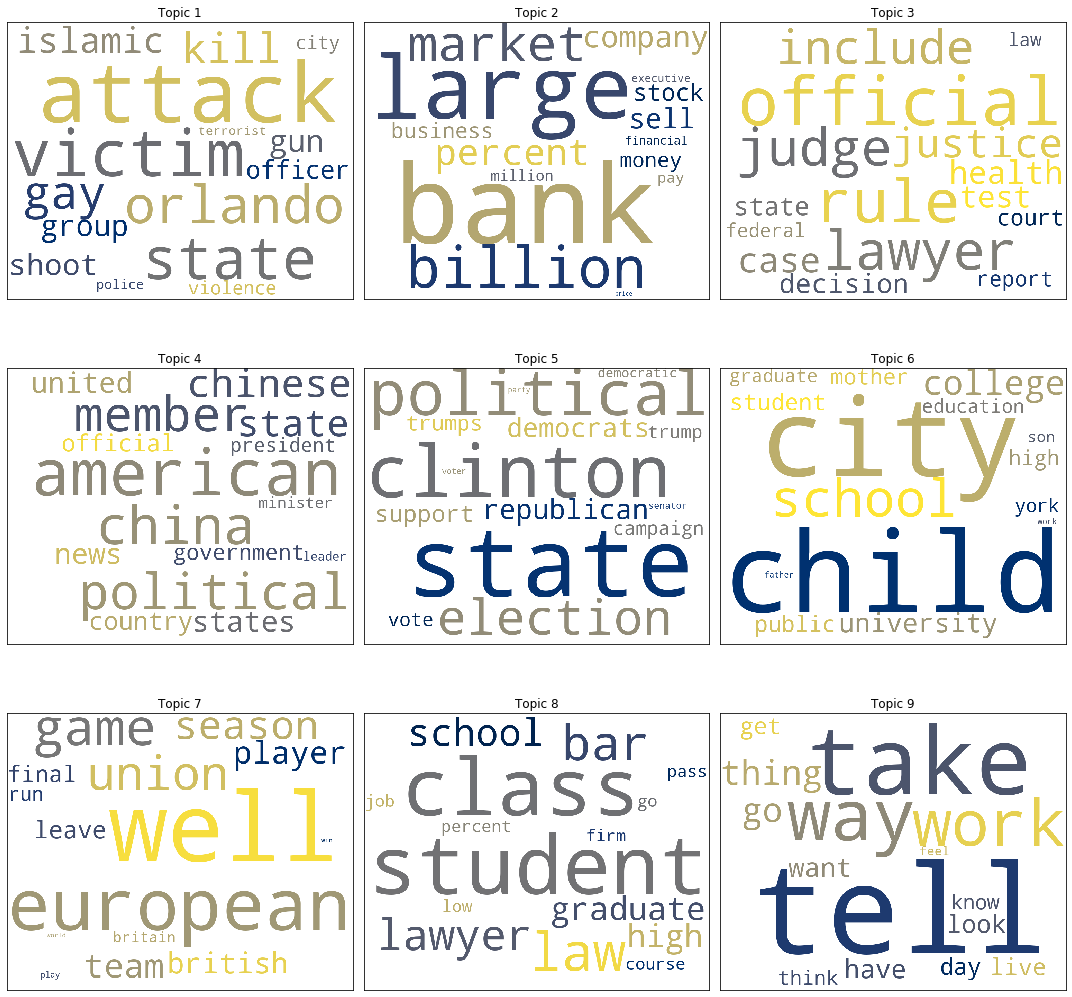

In [14]:
topic_collection = get_topic_keywords(model, features)
plot_wordclouds(topic_collection)